In [62]:
import pandas as pd
import numpy as np

In [252]:
submit = pd.read_csv('/content/drive/MyDrive/2022_WeatherContest_Data/DataSet/jiwhan/2-2_검증데이터셋.csv', encoding='cp949')
hospital = pd.read_csv('/content/drive/MyDrive/2022_WeatherContest_Data/DataSet/jiwhan/hospital.csv', encoding='cp949')
new_merge_data = pd.read_csv('/content/drive/MyDrive/2022_WeatherContest_Data/DataSet/jiwhan/new_merge_data.csv', encoding='cp949')
forecast = pd.read_csv('/content/drive/MyDrive/2022_WeatherContest_Data/DataSet/jiwhan/예보지수.csv', encoding='cp949')

def add_lag_feature(dat, lag = None):

    cols = ['avg_tca_max', 'sum_ss_hr_max', 'ssrate_max', 'avg_rhm_max', 'min_rhm_max', 'sum_rn_max', 
            'max_ws_max','avg_ws_max','max_ta_max', 'min_ta_max', 'PM10_max']
    '''
    cols = ['avg_tca_mean','sum_ss_hr_mean', 'ssrate_mean','avg_rhm_mean', 'min_rhm_mean','sum_rn_mean', 
            'avg_ws_mean', 'max_ws_mean', 'avg_ta_mean', 'max_ta_mean', 'min_ta_mean', 'PM10_mean']
            
    cols = ['avg_tca_mean', 'avg_tca_max','sum_ss_hr_mean','sum_ss_hr_max', 'ssrate_mean', 
            'ssrate_max', 'avg_rhm_mean','avg_rhm_max', 'min_rhm_mean', 'min_rhm_max', 
            'sum_rn_mean', 'sum_rn_max', 'avg_ws_mean', 'avg_ws_max', 'max_ws_mean', 
            'max_ws_max','avg_ta_mean', 'avg_ta_max','max_ta_mean', 'max_ta_max', 
            'min_ta_mean', 'min_ta_max','PM10_mean','PM10_max']
    '''
    
    group_df = dat.groupby(['area'])
    lag_mean = group_df[cols].rolling(window = lag, min_periods=0, closed='left').mean().reset_index(0,drop=True)
   # lag_max = group_df[cols].rolling(window = lag, min_periods=0).max().reset_index(0,drop=True)
    for col in cols:
        dat[f'{col}/mean_lag{lag}'] = lag_mean[col]
   #     dat[f'{col}/max_lag{lag}'] = lag_max[col]
    return dat

new_merge_data = add_lag_feature(new_merge_data.copy(), 2)
new_merge_data = add_lag_feature(new_merge_data.copy(), 4)
new_merge_data = add_lag_feature(new_merge_data.copy(), 7)  

final = pd.merge(hospital, new_merge_data, how='left')
final = pd.merge(final, forecast, how='left')
final = final.sort_values(['yyyymmdd', 'sex', 'area']).reset_index(drop=True)

# 새로운 변수 생성 
dates = pd.to_datetime(final['yyyymmdd'], format='%Y%m%d').dt      
final['weekday']= dates.weekday                                     # 요일 
final['risk_ratio'] = final['num_risk_age'] / final['tot_person']   # 위험인구 비율 
final['day_diff'] = final['max_ta_mean'] - final['min_ta_mean']     # 일교차 
final['temp_humi'] = final['avg_rhm_mean'] * final['avg_ta_mean']   # 습도 * 기온

final['temp_threshold'] = np.where((final['min_ta_mean'] < -1.5), 1, 0)  # 뇌졸중 영향 온도 threshhold

conditionlist = [
    (final['month'].isin([3,4,5])),
    (final['month'].isin([6,7,8])),
    (final['month'].isin([9,10,11])),
    (final['month'].isin([12,1,2]))]
choicelist = [1,2,3,4]
final['season'] = np.select(conditionlist, choicelist, default='Not Specified')  # 계절
final['season'] = final['season'].astype(int)
final['diff_risk'] = np.where(final['day_diff'] >= 10, 1, 0)                     # 일교차 10도 이상 

# 월별 특성(최대,최소,평균,중간)값 시각화 

환자수는 계절성이 없다.

최대,최소,중간 값이 일정하게 증가, 감소하는 컬럼
 - ['avg_ta_mean','avg_ta_max','min_ta_mean','min_ta_max','O3_mean',
'O3_max','max_ta_max/mean_lag2','min_ta_max/mean_lag2',
'A03_t1_mean','A03_t1_max','A03_t2_max','A03_t3_max','A04_t1_mean',
'A04_t1_max','A04_t2_max','A04_t3_max','A05_t1_mean','A05_t1_max',
'A05_t2_max','A05_t3_max','A06_t1_mean','A06_t1_max','A07_t2_mean',
'A07_t2_max']

<Figure size 432x288 with 0 Axes>

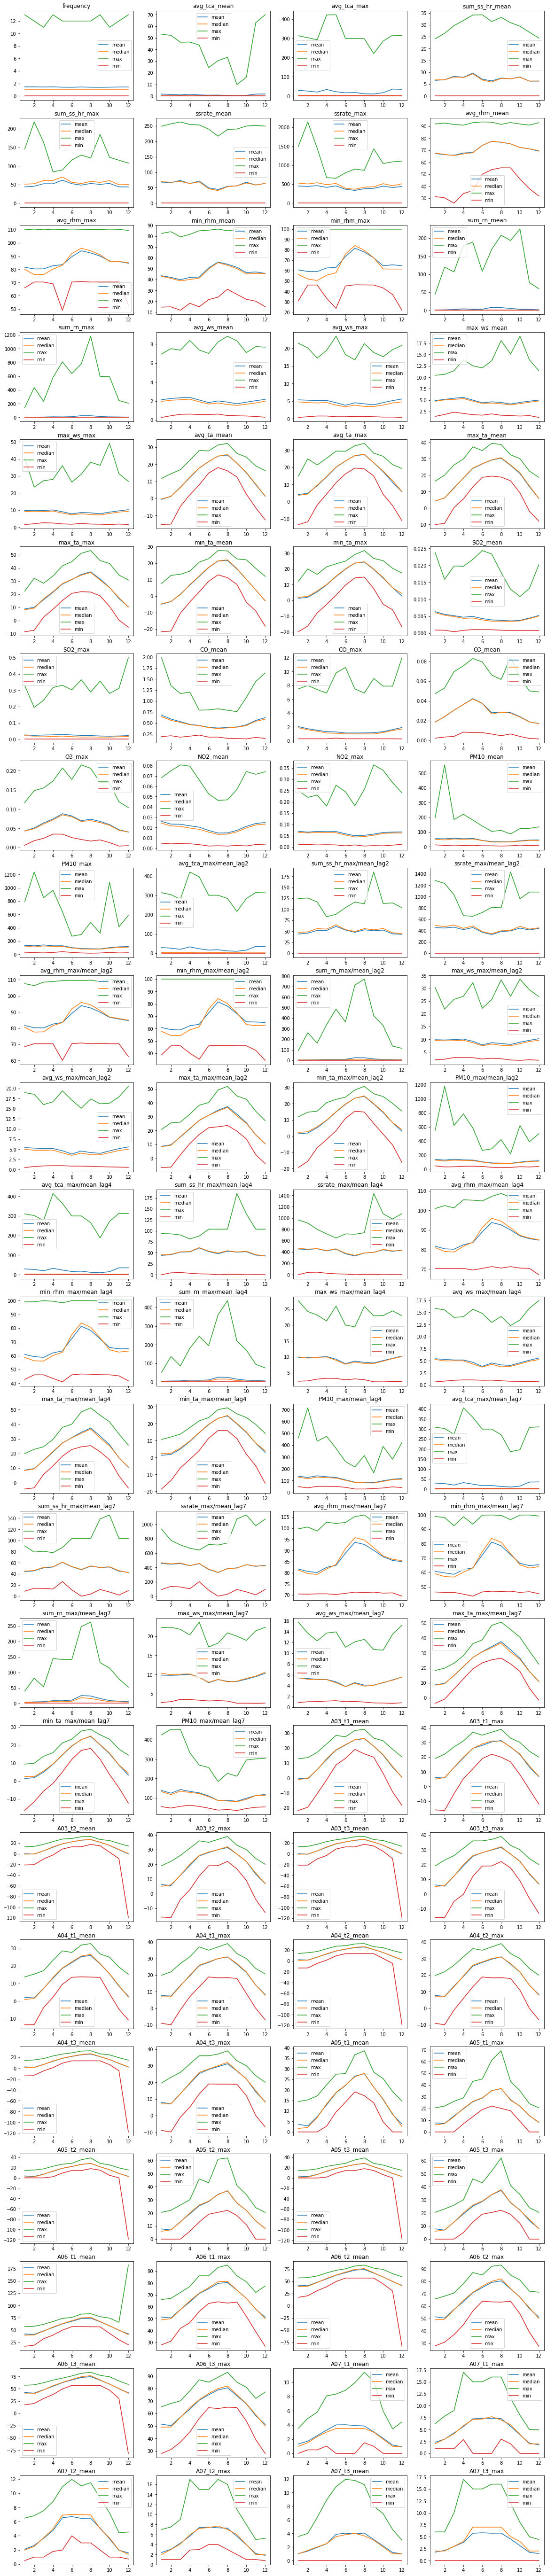

In [224]:
import matplotlib.pyplot as plt

def montilty_check(df):
  the_day_1 = df.groupby(['month'],as_index = False)[['frequency'] + list(df.columns[11:-7])].mean() #평균
  the_day_2 = df.groupby(['month'],as_index = False)[['frequency'] + list(df.columns[11:-7])].median() # 중위값
  the_day_3 = df.groupby(['month'],as_index = False)[['frequency'] + list(df.columns[11:-7])].max() #최댓값
  the_day_4 = df.groupby(['month'],as_index = False)[['frequency'] + list(df.columns[11:-7])].min() # 최솟값

  grid_col = 4
  grid_row = 24

  # 위쪽 margin을 20로 늘리고 수직 간격을 15로 늘립니다
  plt.subplots_adjust(top=40, hspace=20)
  # 아래쪽 margin을 15로 늘립니다
  plt.subplots_adjust(bottom=15)

  plt.figure(figsize=(20, 100))

  x = list(the_day_1['month'])
  for column,idx in zip(the_day_1.columns[1:],range(len(the_day_1.columns[1:]))):
    
    y_1 = list(the_day_1[column])
    y_2 = list(the_day_2[column])
    y_3 = list(the_day_3[column])
    y_4 = list(the_day_4[column])

    plt.subplot(grid_row,grid_col,idx+1)
    plt.plot(x,y_1)
    plt.plot(x,y_2)
    plt.plot(x,y_3)
    plt.plot(x,y_4)
    plt.legend(['mean', 'median','max','min'])

    plt.title(column)
  plt.show()
  del df
montilty_check(final.copy())

# frequency 

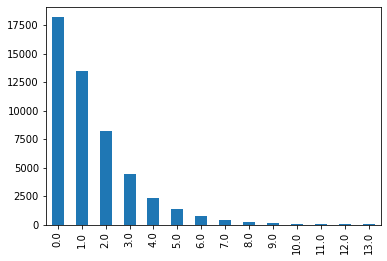

In [253]:
final_cpy = final.copy()

final_cpy['frequency'].value_counts().plot(kind = 'bar')

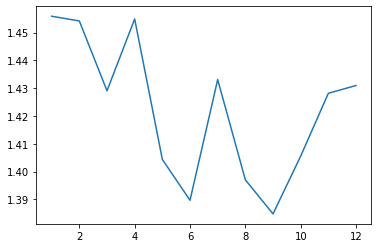

In [254]:
final_cpy = final.copy()
final_cpy = final_cpy.groupby(['month'])[final_cpy.columns].mean()

x = list(final_cpy['month'])
y = list(final_cpy['frequency'])

plt.plot(x,y)
plt.show()

In [255]:
# 새로운 변수 추가
# 월 평균 환자 수 의 평균값보다 많은면 risk_month = 1 ,아니면 risk_month = 0
final_cpy = final.copy()
final_cpy = final_cpy.groupby(['month'])[final_cpy.columns].mean()

mean_sick = final_cpy['frequency'].mean() # 매월 이정도의 환자가 평균적으로 들어온다는 의미?

for year in range(2012,2016+1):
  for month in range(1,12+1):
    if (final.loc[(final['year']==year) & (final['month']==month),'frequency'].mean()) >= mean_sick:
      final.loc[(final['year']==year) & (final['month']==month),'risk_month'] = 1
    else:
      final.loc[(final['year']==year) & (final['month']==month),'risk_month'] = 0

del final_cpy

0.0    38386
1.0    23732
Name: risk_month, dtype: int64



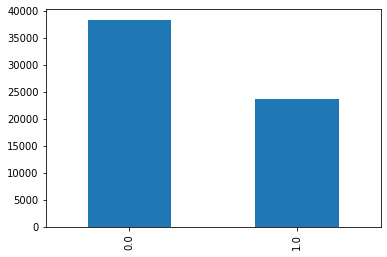

In [261]:
print(final['risk_month'].value_counts())
print()
final['risk_month'].value_counts().plot(kind = 'bar');

In [262]:
final.to_csv('/content/drive/MyDrive/2022_WeatherContest_Data/DataSet/final/final_ver2.csv',encoding='cp949')

# 모델링

In [264]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import RobustScaler
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import StratifiedKFold, KFold
import random
random.seed(42)
np.random.seed(42)

# 모델 평가 지표 
def RMSE(true, pred):
    score = np.sqrt(np.mean(np.square(true-pred)))
    return score

In [265]:
final = pd.read_csv('/content/drive/MyDrive/2022_WeatherContest_Data/DataSet/final/final_ver2.csv',encoding='cp949',index_col=0)

cat_features = ['area']
for i in enumerate(cat_features) :
    ca = i[1]
    final[ca] = final[ca].astype('category')

# train, test split
train = final[final['year'] != 2016].drop('yyyymmdd', axis=1)
test = final[final['year'] == 2016].drop(['frequency', 'yyyymmdd'], axis=1)

X = train.drop('frequency', axis=1)
y = train['frequency']

from sklearn.model_selection import train_test_split,StratifiedKFold, KFold
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2, random_state=42, stratify=X['month'])

# column drop 하는 부분
final = final.drop(['A07_t3_mean','A07_t3_max'], axis=1)

In [266]:
LGBM = LGBMRegressor(objective='mse', verbose=1, metric='rmse', random_state=42, n_jobs=-1,
                     learning_rate=0.05, n_estimators = 3000, max_depth = 100)
# K-Fold 
def kfold(model, tr, num):
    cv_accuracy = []
    cv = KFold(n_splits = num)
    
    n_iter = 0

    for t,v in cv.split(tr, tr['frequency']): 
        train_cv = tr.iloc[t]
        val_cv = tr.iloc[v]

        X = train_cv.drop('frequency', axis=1)
        y = train_cv['frequency']

        val_X = val_cv.drop('frequency', axis=1)
        val_y = val_cv['frequency']

        model.fit(X, y, eval_set=(val_X, val_y), early_stopping_rounds=200, verbose=False)
        score = RMSE(val_y, model.predict(val_X))
        print(f'{n_iter+1} rmse ======> {score}')

        cv_accuracy.append(score)
        n_iter += 1
    
    return np.mean(cv_accuracy)
kfold(LGBM, train, 10)

1 rmse ======> 1.2353741429872678
2 rmse ======> 1.1922569856973246
3 rmse ======> 1.1859293869666194
4 rmse ======> 1.2268513365842084
5 rmse ======> 1.189385226656312
6 rmse ======> 1.206177503869447
7 rmse ======> 1.1888746513755442
8 rmse ======> 1.219344783183815
9 rmse ======> 1.2383102708395226
10 rmse ======> 1.2184279382679157


1.2100932226427976

'avg_ta_mean','avg_ta_max','min_ta_mean','min_ta_max','O3_mean', 'O3_max','max_ta_max/mean_lag2','min_ta_max/mean_lag2', 'A03_t1_mean','A03_t1_max','A03_t2_max','A03_t3_max','A04_t1_mean', 'A04_t1_max','A04_t2_max','A04_t3_max','A05_t1_mean','A05_t1_max', 'A05_t2_max','A05_t3_max','A06_t1_mean','A06_t1_max','A07_t2_mean', 'A07_t2_max'